In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/DATA/ALL_DATA_clean.csv") # read in dataset of reddit posts and other feature info
df = df.drop(labels="level_0",axis=1) # weird data table when reading in so drop this column to fix!
#df.head() # display the first few rows to check...
texts = pd.DataFrame() # ONLY NEED the post text from the dataframe
texts['text'] = df['Text']
texts.head() # check to make sure this only has the post text in dataframe...

Mounted at /content/drive


,text
0,i have one pill left. \ni should have gone las...
1,my health insurance doesn't really do anything...
2,\ni’ve been sick for a week so the next time i...
3,i wonder if i should ask for a lower dose or s...
4,i’ve been on adderall for about a year. start...


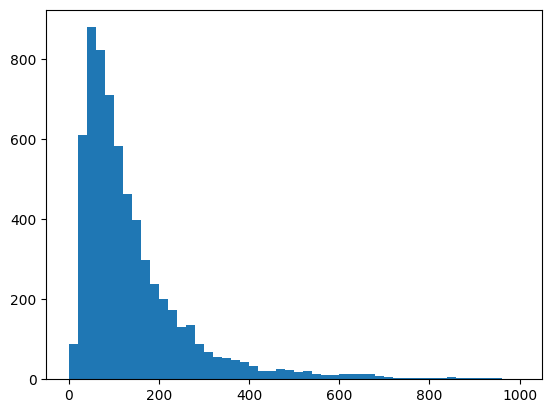

In [3]:
word_counts = [] # plot a distribution of word counts of each post in the dataset...
for item in texts['text']:
  word_counts.append(len(item.split()))
plt.hist(word_counts, bins=50, range = [0,1000]) # upperbound is 5,797!
plt.show()

## Filter Posts

Remove posts with a word count above 500 OR below 20 (6,124 posts remaining)...

In [4]:
indices_above500  = [index for (index, item) in enumerate(word_counts) if item > 500]
indices_below20  = [index for (index, item) in enumerate(word_counts) if item < 20]
filter_indices = indices_above500+indices_below20 # 293 posts

In [5]:
texts = texts.drop(filter_indices)
texts = texts.reset_index()
print("Total Number of Posts After Filtering: " + str(len(texts)))

Total Number of Posts After Filtering: 6124


## Split Data into Testing (70%) and Training (30%) Sets

In [6]:
train_prop = 0.70
train_size = int(len(texts['text'])*train_prop)
test_size = len(texts['text']) - train_size
print("Number of Posts in Train Set = " + str(train_size) + " vs Number of Posts in Test Set = " + str(test_size))

Number of Posts in Train Set = 4286 vs Number of Posts in Test Set = 1838


In [7]:
import random
random.seed(42) # for replication purposes (same shuffle every time)

indices = list(range(0,len(texts['text'])))
random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

In [8]:
TRAIN_DATA = texts.drop(test_indices)
TRAIN_DATA = TRAIN_DATA.reset_index()
TRAIN_DATA = TRAIN_DATA.drop(['level_0','index'], axis=1)

TEST_DATA = texts.drop(train_indices)
TEST_DATA = TEST_DATA.reset_index()
TEST_DATA = TEST_DATA.drop(['level_0','index'], axis=1)

NOTE: Because annotation took wayyy too long and I did not have enough time to annotate over 4000 posts, I choose to only use the first 2001 posts from the TRAIN_DATA subset. Specifically, I used the first 401 of these posts (20% of 2001) as a test set and the last 1600 (80% of 2001) for training purposes (all 2001 posts were manually annotated using brat tools)...

In [9]:
subset = TRAIN_DATA[0:2001] # all data I was able to mannually annotate!
TRAIN_DATA = subset[401:2001] # smaller train set
TEST_DATA = subset[0:401] # smaller test set

In [10]:
TRAIN_DATA.head()

,text
401,this might seem like a silly post - but i've o...
402,i've been off of it for over 3 years (personal...
403,i’m so confused! please has anyone felt this? ...
404,"i’m on 5mg, but will take 10mg when needed in ..."
405,"hey all,\nso i recently got diagnosed with adh..."


In [11]:
len(TEST_DATA)

401

ALREADY DONE SO DO NOT RUN: SAVE NEW TRAINING AND TEST DATA TO CSV...

In [12]:
spath = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing'
TRAIN_DATA.to_csv(spath+'/TRAIN.csv')
TEST_DATA.to_csv(spath+'/TEST.csv')

## DO NOT RUN (Already Completed): Write Training Data Posts to a Folder on Drive

Where each file in the folder is a post with the text lowercased and with carriage returns and URLs removed...

In [ ]:

import re
url_pattern = re.compile(r'https?://\S+|www\.\S+') # in order to remove URLs

train_path = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/data_annotation/train/' # folder to save all training post files to

for i in range(0, len(TRAIN_DATA['text'])): # loop through every post in training set

  text = url_pattern.sub("", TRAIN_DATA['text'][i]) # remove any urls from given post
  text = text.replace("\n","") # remove return characters
  text = text.lower() # lowercase text

  fpath = train_path+"TN_"+str(i)+".txt" # for each post, filename will begin with TN then the post number (e.g TN_10)

  # write the text of the given post to a file in the specified folder...
  with open(fpath, "w") as text_file:
    text_file.write(text)


## DO NOT RUN (Already Completed): Write Test Posts to a Folder on Drive

Same thing as above but done for the posts in the testing set...

In [ ]:
test_path = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/data_annotation/test/'
for i in range(0, len(TEST_DATA['text'])):
  text = url_pattern.sub("", TEST_DATA['text'][i])
  text = text.replace("\n","")
  text = text.lower()
  fpath = test_path+"TT_"+str(i)+".txt" # this time name with TT_ instead of TN_
  with open(fpath, "w") as text_file:
    text_file.write(text)

## Simple Tokenize Function

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def make_tokens(data):
  for item in data:
    new_item = item.replace("\n","")
    yield(word_tokenize(new_item)) # tokenize a given post

basic_tokens_train = list(make_tokens(TRAIN_DATA['text']))
basic_tokens_test = list(make_tokens(TEST_DATA['text']))
basic_tokens = list(make_tokens(texts['text']))

## Total Number of Word & Non-Word Tokens

In [ ]:
import string # use string.punctuation for non word determination...

def all_words_and_nonwords(basic_tokens):

  total_words = 0 # any other token besides punctuation
  total_nonwords = 0 # tokens that are punctuation

  for post in basic_tokens: # loop through each post (should be a list of tokens)
    for word_piece in post: # loop through each token in the list
      if word_piece not in string.punctuation:
        total_words = total_words+1
      else:
        total_nonwords = total_nonwords+1

  print("Total Number of 'Words' - "+str(total_words))
  print("Total Number of 'Non-Words' - "+str(total_nonwords))
  return (total_words, total_nonwords)

Get total number of word tokens and non-word tokens for both the original dataset and also the training and test set splits...

In [ ]:
all = all_words_and_nonwords(basic_tokens)
train_words = all_words_and_nonwords(basic_tokens_train)
test_words = all_words_and_nonwords(basic_tokens_test)

Total Number of 'Words' - 817637
Total Number of 'Non-Words' - 82760
Total Number of 'Words' - 223082
Total Number of 'Non-Words' - 22133
Total Number of 'Words' - 50350
Total Number of 'Non-Words' - 5131


## Vocabulary Size (Total Number of Unique Tokens)

In [ ]:
def get_unique_tokens(basic_tokens):
  unique_tokens = dict()
  for post in basic_tokens:
    for token in post:
      if token not in unique_tokens.keys():
        unique_tokens[token] = 1
      else:
        unique_tokens[token] = unique_tokens[token]+1

  sorted_unique_tokens = {k: v for k, v in sorted(unique_tokens.items(), key=lambda item: item[1], reverse=True)}
  print("Total Number of Unique Tokens - "+str(len(sorted_unique_tokens.keys())))
  return(sorted_unique_tokens)

In [ ]:
total_unique_tokens = get_unique_tokens(basic_tokens)
total_unique_tokens_train = get_unique_tokens(basic_tokens_train)
total_unique_tokens_test = get_unique_tokens(basic_tokens_test)

Total Number of Unique Tokens - 23305
Total Number of Unique Tokens - 11119
Total Number of Unique Tokens - 5143


## Number of Wordpiece Tokens

In [ ]:
#texts.to_csv("/content/drive/MyDrive/DATA/adderall_texts_FILTERED.csv")

In [ ]:
model_ckpt = 'allenai/longformer-base-4096'
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) #  use Longformer tokenizer (BERT-like model suited for long texts)
MAX_LENGTH = 1024 # model params (not sure if this is the true max...)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
!pip3 install datasets
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
hugging_data = load_dataset("csv", data_files="/content/drive/MyDrive/DATA/adderall_texts_FILTERED.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
hugging_data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'index', 'text'],
        num_rows: 6124
    })
})

In [ ]:
def tokenization(sample):
  return tokenizer(sample["text"], truncation=True) # most sentences are too long so we must truncate!

In [ ]:
wordpiece_tokens = hugging_data.map(tokenization, batched=True) # generally a post has more wordpiece tokens (can split one word into two) than tokens

Map:   0%|          | 0/6124 [00:00<?, ? examples/s]

In [ ]:
unique_wordpiece = dict()
for post in wordpiece_tokens['train']['input_ids']:
  for token in post:
      if token not in unique_wordpiece.keys():
        unique_wordpiece[token] = 1
      else:
        unique_wordpiece[token] = unique_wordpiece[token]+1

sorted_unique_wordpiece = {k: v for k, v in sorted(unique_wordpiece.items(), key=lambda item: item[1], reverse=True)}
print("Total Number of Unique Wordpiece Tokens - "+str(len(sorted_unique_wordpiece.keys())))


Total Number of Unique Wordpiece Tokens - 15119


In [ ]:
print("Total Number of Wordpiece Tokens - "+str(sum(sorted_unique_wordpiece.values())))


Total Number of Wordpiece Tokens - 1038932


## Sentence Tokenizer

In [ ]:
from nltk.tokenize import sent_tokenize

def make_sentences(data):
  for item in data:
    new_item = item.replace("\n","")
    yield(sent_tokenize(new_item)) # tokenize a given post

sentences_train = list(make_sentences(TRAIN_DATA['text']))
sentences_test = list(make_sentences(TEST_DATA['text']))
sentences = list(make_sentences(texts['text']))

In [ ]:
def count_sentences(data):
  num_sentences = 0
  for post in data:
    num_sentences = num_sentences + len(post)
  return(num_sentences)

print("Total Number of Sentences - " + str(count_sentences(sentences)))
print("Total Number of Sentences (TRAIN) - " + str(count_sentences(sentences_train)))
print("Total Number of Sentences (TEST) - " + str(count_sentences(sentences_test)))

Total Number of Sentences - 41878
Total Number of Sentences (TRAIN) - 29507
Total Number of Sentences (TEST) - 12371
